# QQQ prices prediction

We are going to predict the price of QQQ using the following methods:
1. LSTM
2. Facebook Prophet
3. ARIMA

## Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Using device:  cuda


## Data opening and basic functions

In [2]:
def open_data(print_head=False, print_shape=False):
    df = pd.read_csv('Data\\QQQ_full.csv', header=0, parse_dates=True)
    del df['Unnamed: 0']
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df.set_index('Date', inplace=True)
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = df['Volume'].astype(float)
    df = df.dropna()
    df = df.reset_index(drop=True)
    if print_shape:
        print(df.shape)
    if print_head:
        print(df.head())
    return df

def plot_data(df, columns = ['Close']):
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        plt.plot(df[col], label=col)
        plt.title(col, y=0.5, loc='right')
    plt.show()

(1195, 17)
     Open    High     Low   Close      Volume  1-month  3-month  6-month  \
0  150.99  155.75  150.88  154.88  58576672.0     2.40     2.42     2.51   
1  152.60  153.26  149.49  149.82  74820234.0     2.42     2.41     2.47   
2  152.18  157.00  151.74  156.23  74709320.0     2.40     2.42     2.51   
3  156.54  158.86  156.11  158.09  52059328.0     2.42     2.45     2.54   
4  159.56  160.11  157.20  159.52  49388688.0     2.40     2.46     2.54   

   1-year  2-year  3-year  5-year  7-year  10-year  20-year  30-year  \
0    2.60    2.50    2.47    2.49    2.56     2.66     2.83     2.97   
1    2.50    2.39    2.35    2.37    2.44     2.56     2.75     2.92   
2    2.57    2.50    2.47    2.49    2.56     2.67     2.83     2.98   
3    2.58    2.53    2.51    2.53    2.60     2.70     2.86     2.99   
4    2.60    2.58    2.57    2.58    2.63     2.73     2.88     3.00   

   Inflation  
0        2.2  
1        2.2  
2        2.2  
3        2.2  
4        2.2  


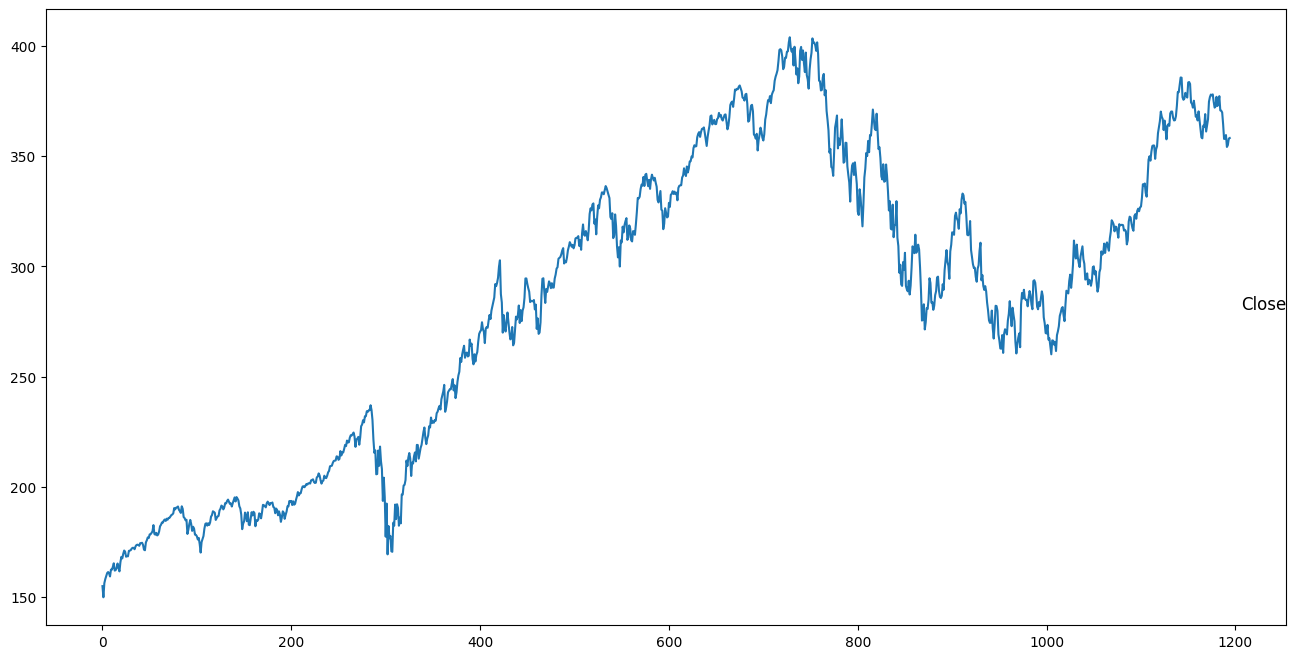

In [3]:
df = open_data(print_head=True, print_shape=True)
plot_data(df)

## Data exploration
We plan to use the predicting closing price of QQQ as the next day's opening price. 
We want to check if there is a huge difference between the closing price and the opening price.

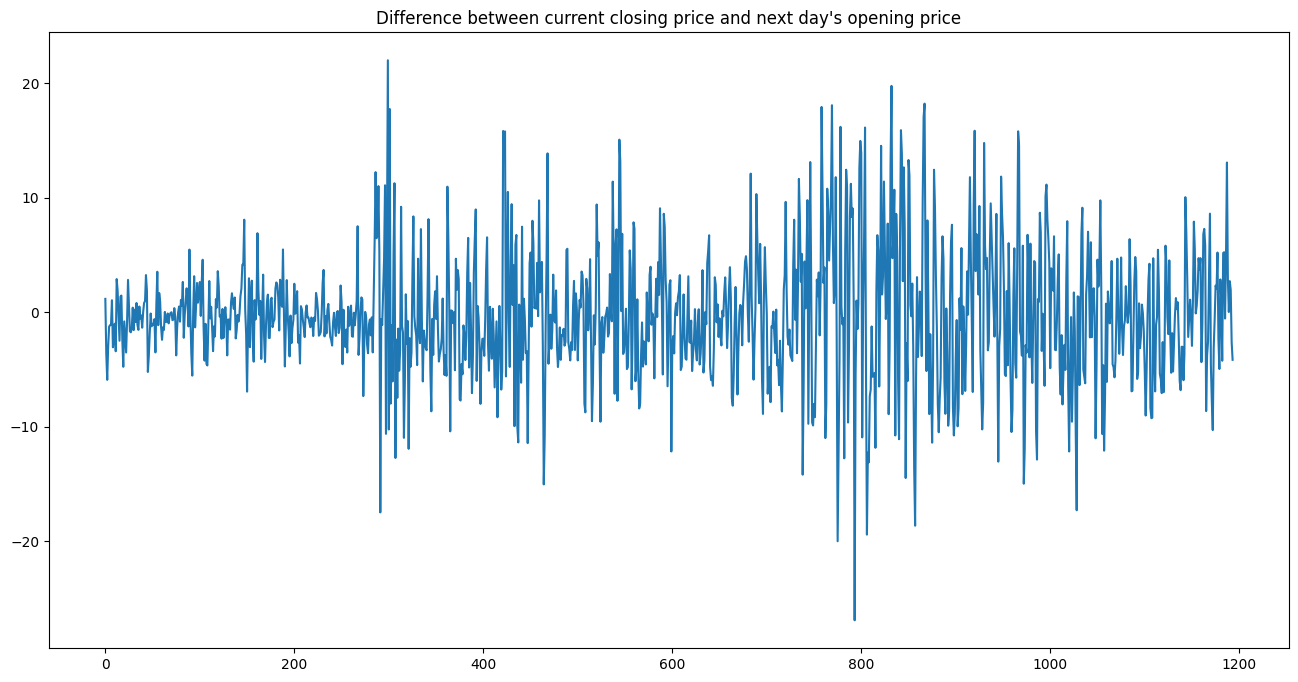

In [22]:
# Plot the difference between the current closing price and next day's opening price

diff = df['Open'] - df['Close'].shift(-1)
plt.figure(figsize=(16, 8))
plt.plot(diff)
plt.title('Difference between current closing price and next day\'s opening price')
plt.show()

As we see from the plot, the difference between the closing price and the opening price is quite huge, and has a high variance. 
Therefore, we are gonna use the it for a day to day strategy, and we will consider that we have access to the current day's opening price.

# Prediction with LSTM

## Data preparation

In [16]:
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y = df['Close']
X = df.drop('Close', axis=1)

# We are going to predict the next closing price using the previous 60 closing prices
y = y[X.index]

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

class StockDataset(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        return self.X[start:end], self.y[end-1]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset(X_train, y_train)
test_set = StockDataset(X_test, y_test)

In [18]:
print("Train set size: ", len(train_set))
# orint the first 5 samples
for i in range(5):
    print(train_set[i])

Train set size:  896
(tensor([[-1.0000e+00, -9.8050e-01, -9.8902e-01, -4.6467e-01, -2.0266e-01,
         -1.3725e-01, -1.0912e-01, -6.0550e-02, -4.1750e-02, -1.0438e-02,
          2.6786e-02,  1.6166e-02,  4.6455e-02, -3.2099e-02,  5.8824e-02,
         -6.2963e-01],
        [-9.8735e-01, -1.0000e+00, -1.0000e+00, -2.9578e-01, -1.9601e-01,
         -1.4082e-01, -1.2343e-01, -9.7248e-02, -8.5487e-02, -6.0543e-02,
         -2.6786e-02, -3.9261e-02, -2.4450e-03, -7.1605e-02,  3.2086e-02,
         -6.2963e-01],
        [-9.9065e-01, -9.7072e-01, -9.8222e-01, -2.9694e-01, -2.0266e-01,
         -1.3725e-01, -1.0912e-01, -7.1560e-02, -4.1750e-02, -1.0438e-02,
          2.6786e-02,  1.6166e-02,  5.1345e-02, -3.2099e-02,  6.4171e-02,
         -6.2963e-01],
        [-9.5640e-01, -9.5616e-01, -9.4769e-01, -5.3243e-01, -1.9601e-01,
         -1.2656e-01, -9.8390e-02, -6.7890e-02, -2.9821e-02,  6.2630e-03,
          4.4643e-02,  3.4642e-02,  6.6015e-02, -1.7284e-02,  6.9519e-02,
         -6.2963e-01]

## Model definition

In [36]:
# Define the LSTM model

class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear2(self.linear(lstm_out.view(len(seq),-1)))
        return pred[-1]
    
# Define a 2nd bigger LSTM model with 2 LSTM layers and 3 fully-connected layers

class LSTMnetwork2(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 2 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.linear2(self.linear(lstm_out2.view(len(seq),-1))))
        return pred[-1]
    
# Define a 3rd bigger LSTM model with 2 LSTM layers, 3 fully-connected layers and dropout, RELU activation function and l1 regularization

class LSTMnetwork3(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 3 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)

        # add dropout layer:
        self.dropout = nn.Dropout(0.2)

        # add RELU activation function:
        self.relu = nn.ReLU()
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.dropout(self.relu(self.linear2(self.relu(self.linear(lstm_out2.view(len(seq),-1)))))))
        return pred[-1]

## Model training

In [37]:
input_size = len(X_train[0])
model = LSTMnetwork3(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

model

LSTMnetwork3(
  (lstm1): LSTM(16, 100)
  (lstm2): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [38]:
epochs = 30

losses = []

best_model = None
best_loss = 1000000

for i in range(epochs):
    for seq, y_train in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_train in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_train)
    print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

Epoch 0 Loss: 0.003524651750922203
Test loss: 0.3786516785621643
Epoch 1 Loss: 0.004159377887845039
Test loss: 0.7735263705253601
Epoch 2 Loss: 0.039276402443647385
Test loss: 0.2470884919166565
Epoch 3 Loss: 2.794997499222518e-06
Test loss: 0.48838138580322266
Epoch 4 Loss: 0.05966632440686226
Test loss: 0.21356406807899475
Epoch 5 Loss: 2.5923388875526143e-06
Test loss: 0.5791177749633789
Epoch 6 Loss: 0.0647156834602356
Test loss: 0.21617577970027924
Epoch 7 Loss: 0.048550739884376526
Test loss: 0.24066706001758575
Epoch 8 Loss: 0.010168426670134068
Test loss: 0.4819453954696655
Epoch 9 Loss: 0.001125769573263824
Test loss: 0.44272270798683167
Epoch 10 Loss: 0.03308384120464325
Test loss: 0.3357904255390167
Epoch 11 Loss: 0.00023130395857151598
Test loss: 0.4504466950893402
Epoch 12 Loss: 0.004744816571474075
Test loss: 1.4063504934310913
Epoch 13 Loss: 0.0003148704709019512
Test loss: 1.044420838356018
Epoch 14 Loss: 1.2538444934762083e-05
Test loss: 0.5352053046226501
Epoch 15 Los

KeyboardInterrupt: 

## Model evaluation and saving

We are now going to evaluate the model and save it.
We first want to graphicly see the results of the prediction. We are going to plot the prediction and the real values.

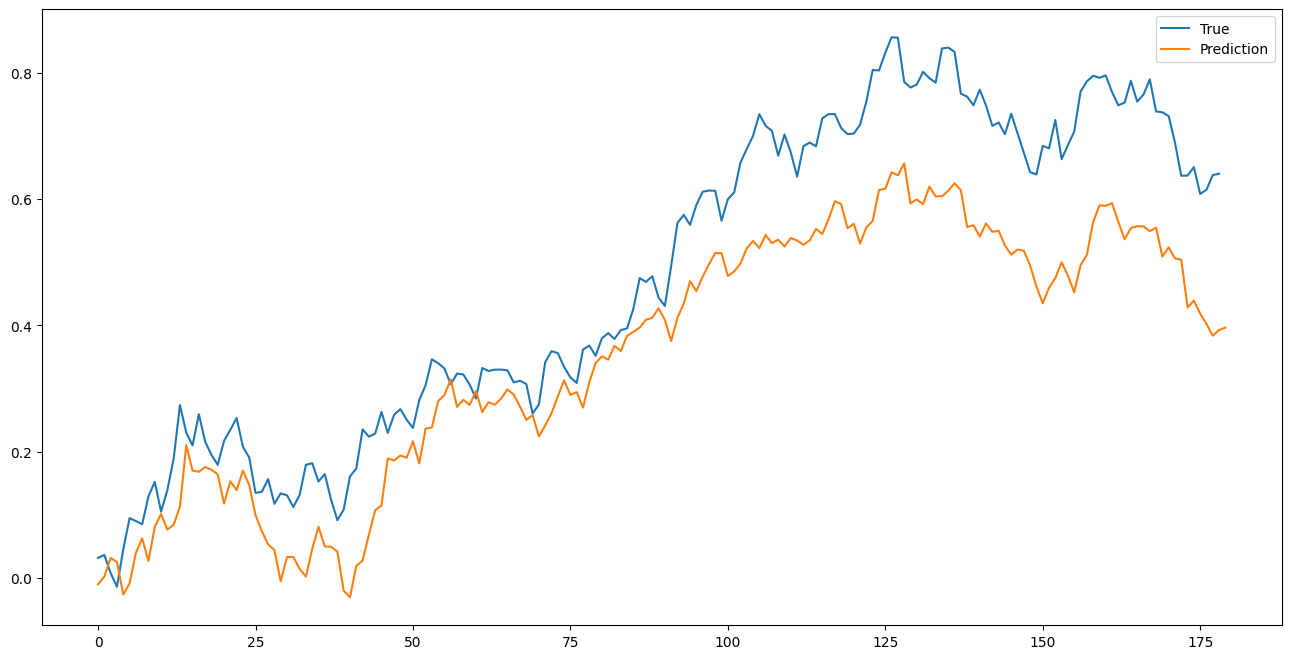

In [31]:
# predict the test set
test_preds = []
for seq, _ in test_set:
    best_model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                    torch.zeros(1, 1, model.hidden_size).to(device))
    with torch.no_grad():
        test_pred = model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(list(y_test)[60:], label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

In [32]:
# Save the whole best model
torch.save(best_model, 'best_model_2lstm_2.pt')

# Prediction with Facebook Prophet

# Prediction with ARIMA